In [16]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)
from tqdm import tqdm
from collections import OrderedDict

from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display

# Utilities
from aif360.utils.general_utils import compute_metrics
from aif360.utils.classifier_metrics import ClassifierMetricUtils

import matplotlib.pyplot as plt

# Explainers
from aif360.explainers import MetricTextExplainer

In [10]:
dataset_orig = CompasDataset(
    protected_attribute_names=['sex'],
    privileged_classes=[['Female']],
    features_to_drop=['race', 'age']
)

dataset_orig_train, dataset_orig_val, dataset_orig_test = dataset_orig.split([0.5,0.8], shuffle=True)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [11]:
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [12]:
dataset_orig_valid_pred = dataset_orig_val.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [19]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_val,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    print(classified_metric_orig_valid.binary_confusion_matrix())
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

{'TP': 989.0, 'FP': 817.0, 'TN': 27.0, 'FN': 17.0}
{'TP': 988.0, 'FP': 812.0, 'TN': 32.0, 'FN': 18.0}
{'TP': 988.0, 'FP': 806.0, 'TN': 38.0, 'FN': 18.0}
{'TP': 988.0, 'FP': 803.0, 'TN': 41.0, 'FN': 18.0}
{'TP': 986.0, 'FP': 791.0, 'TN': 53.0, 'FN': 20.0}
{'TP': 985.0, 'FP': 785.0, 'TN': 59.0, 'FN': 21.0}
{'TP': 985.0, 'FP': 781.0, 'TN': 63.0, 'FN': 21.0}
{'TP': 985.0, 'FP': 775.0, 'TN': 69.0, 'FN': 21.0}
{'TP': 982.0, 'FP': 770.0, 'TN': 74.0, 'FN': 24.0}
{'TP': 981.0, 'FP': 764.0, 'TN': 80.0, 'FN': 25.0}
{'TP': 979.0, 'FP': 759.0, 'TN': 85.0, 'FN': 27.0}
{'TP': 979.0, 'FP': 759.0, 'TN': 85.0, 'FN': 27.0}
{'TP': 978.0, 'FP': 754.0, 'TN': 90.0, 'FN': 28.0}
{'TP': 977.0, 'FP': 747.0, 'TN': 97.0, 'FN': 29.0}
{'TP': 975.0, 'FP': 742.0, 'TN': 102.0, 'FN': 31.0}
{'TP': 975.0, 'FP': 735.0, 'TN': 109.0, 'FN': 31.0}
{'TP': 975.0, 'FP': 728.0, 'TN': 116.0, 'FN': 31.0}
{'TP': 972.0, 'FP': 721.0, 'TN': 123.0, 'FN': 34.0}
{'TP': 970.0, 'FP': 713.0, 'TN': 131.0, 'FN': 36.0}
{'TP': 970.0, 'FP': 707.0,

In [14]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

 35%|███▌      | 35/100 [00:00<00:00, 197.66it/s]

Classification threshold used = 0.5643


100%|██████████| 100/100 [00:00<00:00, 337.87it/s]

Balanced accuracy = 0.6440
Statistical parity difference = -0.3485
Disparate impact = 0.5486
Average odds difference = -0.3282
Equal opportunity difference = -0.3154
Theil index = 0.2855


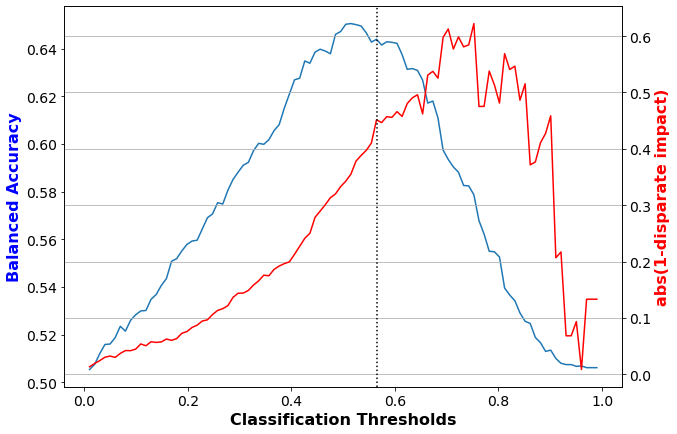

In [17]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [7]:
# Compute metrics for best thresh
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

classifier_metrics = ClassifierMetricUtils(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups)

classifier_metrics.compute_metrics()

Balanced accuracy = 0.6440
Statistical parity difference = -0.3485
Disparate impact = 0.5486
Average odds difference = -0.3282
Equal opportunity difference = -0.3154
Theil index = 0.2855


In [84]:
classifier_metric = utils.compute_metrics(dataset_orig_test,
                                                    dataset_orig_test_pred,
                                                    unprivileged_groups, privileged_groups)
utils.get_metric(classifier_metric)
utils.get_explanation(classifier_metric)

Balanced accuracy = 0.6440
Statistical parity difference = -0.3485
Disparate impact = 0.5486
Average odds difference = -0.3282
Equal opportunity difference = -0.3154
Theil index = 0.2855


AttributeError: module 'aif360.utils.common_utils' has no attribute 'get_metric'